In [27]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_parquet('../data/processed/preprocessed_prophet_15min.parquet')
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
y = df["recommended_fee_fastestFee"]
X = df.drop(columns = "recommended_fee_fastestFee")

# shift
shift_steps = 96 # shift 24h
X = X.shift(periods=shift_steps)
X.dropna(inplace=True)
df = df.loc[X.index]
y = y.loc[X.index]

# last 24h as test
split_index = len(X) - 96
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

df = df.iloc[:split_index]

X = X.reset_index()
X = X.drop(columns = "timestamp")

In [4]:
df = df.reset_index()
df_prophet = df[['timestamp', 'recommended_fee_fastestFee']].rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet.head()

,ds,y
0,2025-03-06 02:00:00,2.666667
1,2025-03-06 02:15:00,2.666667
2,2025-03-06 02:30:00,3.000000
3,2025-03-06 02:45:00,2.666667
4,2025-03-06 03:00:00,2.333333


In [5]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)

In [6]:
for i in X.columns.values:
    df_prophet[i] = X[i].copy()
    model.add_regressor(i)

In [7]:
df_prophet.head()

,ds,y,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
0,2025-03-06 02:00:00,2.666667,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,2.000000,2.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-03-06 02:15:00,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,2.666667,2.666667,2.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-03-06 02:30:00,3.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-03-06 02:45:00,2.666667,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-03-06 03:00:00,2.333333,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.000000,3.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_prophet.dropna(inplace=True)
model.fit(df_prophet)

23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing


### Predict

In [9]:
future = model.make_future_dataframe(periods=96, freq='15min')

for i in X.columns.values:
    future[i] = list(df_prophet[i]) + list(X_test[i])

forecast = model.predict(future)

In [13]:
forecast.index = y.index
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,recommended_fee_minimumFee,recommended_fee_minimumFee_lower,recommended_fee_minimumFee_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-06 02:00:00,2025-03-06 02:00:00,3.312809,0.052330,5.844586,3.312809,3.312809,-0.408769,-0.408769,-0.408769,-0.487295,...,-0.593322,-0.593322,-0.593322,-0.013338,-0.013338,-0.013338,0.0,0.0,0.0,2.904040
2025-03-06 02:15:00,2025-03-06 02:15:00,3.313017,-0.200682,5.523048,3.313017,3.313017,-0.600309,-0.600309,-0.600309,-0.486595,...,-0.593322,-0.593322,-0.593322,-0.011434,-0.011434,-0.011434,0.0,0.0,0.0,2.712708
2025-03-06 02:30:00,2025-03-06 02:30:00,3.313224,0.258319,5.988876,3.313224,3.313224,-0.388316,-0.388316,-0.388316,-0.488339,...,-0.593322,-0.593322,-0.593322,-0.009449,-0.009449,-0.009449,0.0,0.0,0.0,2.924908
2025-03-06 02:45:00,2025-03-06 02:45:00,3.313431,0.266140,5.516952,3.313431,3.313431,-0.367387,-0.367387,-0.367387,-0.493352,...,-0.593322,-0.593322,-0.593322,-0.007387,-0.007387,-0.007387,0.0,0.0,0.0,2.946044
2025-03-06 03:00:00,2025-03-06 03:00:00,3.313638,0.363803,5.445713,3.313638,3.313638,-0.545353,-0.545353,-0.545353,-0.502135,...,-0.593322,-0.593322,-0.593322,-0.005250,-0.005250,-0.005250,0.0,0.0,0.0,2.768285


In [24]:
y_pred = forecast.iloc[-96:]
y_pred = y_pred["yhat"]
y_pred.head()

timestamp
2025-04-14 10:00:00    2.518095
2025-04-14 10:15:00    2.119359
2025-04-14 10:30:00    2.189353
2025-04-14 10:45:00    3.838992
2025-04-14 11:00:00    1.872807
Name: yhat, dtype: float64

In [25]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

MAE: 1.2093
RMSE: 1.4661
MAPE: 0.6091


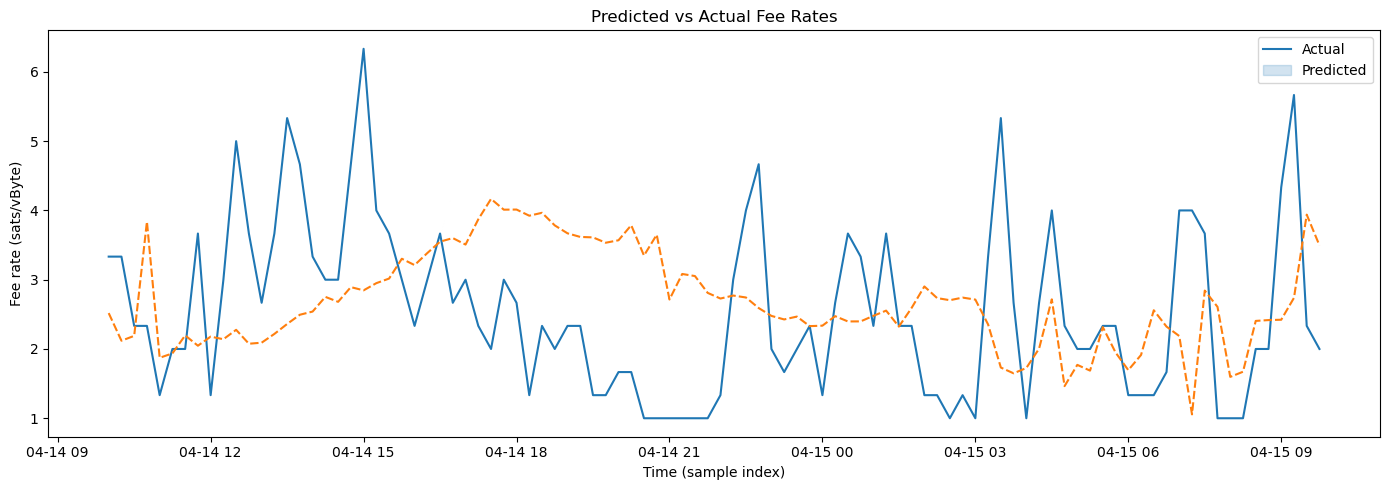

In [28]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=y_test.index)

plt.figure(figsize=(14, 5))
sns.lineplot(data=result_df)
plt.title('Predicted vs Actual Fee Rates')
plt.xlabel('Time (sample index)')
plt.ylabel('Fee rate (sats/vByte)')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()